In [1]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 가우스 노이즈
# noiy_pixel = original_pixel + N(u=0, e = scale)
# 평균 = 0 : 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차 = sacle-> 값이 클수록 노이즈가 강해짐
# 0.8 - > 노이즈의 양 많고.. 숫자 일부를 흐릿

In [ ]:
gaussian_data_x = np.random.normal(
        loc = 0, scale =0.8, size = (1,28,28)
    )
gaussian_data_x.shape

np.clip(gaussian_data_x, 0 , 1) 

array([[[0.30514661, 0.833597  , 0.22960443, 0.18257816, 0.        ,
         1.        , 1.        , 0.20515044, 1.        , 0.        ,
         0.46448214, 0.        , 0.        , 0.05731997, 0.34666536,
         0.84687448, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.18219875, 0.        , 0.        , 1.        ,
         0.12021162, 1.        , 0.        ],
        [0.88661863, 0.37573889, 0.        , 1.        , 1.        ,
         0.07372879, 1.        , 0.        , 0.30278095, 0.        ,
         0.16553861, 0.        , 0.23244621, 1.        , 1.        ,
         0.1948915 , 0.        , 0.        , 0.        , 0.        ,
         0.22451731, 0.        , 0.65947007, 0.        , 0.48118014,
         0.        , 0.24356017, 0.        ],
        [0.        , 0.4350478 , 0.        , 0.93979288, 0.37991864,
         1.        , 0.        , 0.        , 0.        , 1.        ,
         0.42203193, 0.        , 1.        , 0.        , 0.        ,
         0.

In [2]:
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x +  np.random.normal(
        loc = 0, scale =scale, size = x.shape
    )
    gaussian_data_x = np.clip(gaussian_data_x,0,1)  # 이미지픽셀의 값을 0과 1사이로 정규화
    gaussian_data_x = torch.tensor(gaussian_data_x,dtype=torch.float32)
    return gaussian_data_x

In [ ]:
traning_data = MNIST(root='./', train=True, download=True,transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True,transform=ToTensor())

torch.Size([1, 28, 28])


C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x +  np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x,dtype=torch.float32)


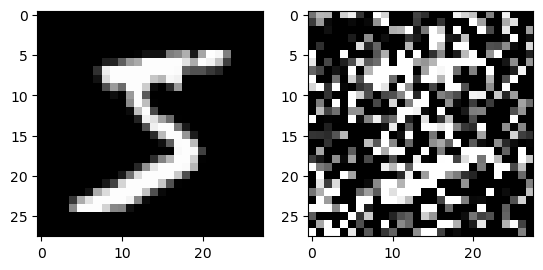

In [36]:
img,label = next(iter(traning_data))
print(img.shape)
gaussian = gaussian_noise(img)
img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gaussian,cmap='gray')

In [28]:
for data, label in traning_data:
    noisy = gaussian_noise(data)
    print(type(noisy), noisy.size())
    break

<class 'torch.Tensor'> torch.Size([1, 28, 28])


C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x +  np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x,dtype=torch.float32)


In [60]:
# 학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./', train=True, download=True,transform=ToTensor())
        self.data = []
        # 잡음 입히기
        for data, label in self.mnist:
            noisy =  gaussian_noise(data)  # 0 ~ 1사이로 맞춤
            self.data.append(noisy) # (1, 28, 28)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index]
        label = self.mnist.data[index] / 255  # 원본이미지도 0 ~1 정규화
        return data, label

In [33]:
# 합성곱 기본 블럭
import torch.nn as nn
# conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel,hidden_channel):
        super(BasicBlock,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel,kernel_size=3,padding=1),
            nn.ReLU()
        )
    def forward(self,x):
        return self.model(x)

In [35]:
sample_data = torch.randn(1,1,28,28)
sample_model = BasicBlock(1,20,10)
sample_model(sample_data).size()

torch.Size([1, 20, 28, 28])

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1,16,14,41
        out = self.pool(self.conv2(x)) # 1, 8,7,7
        return out

In [46]:
sample_data = torch.randn(1,1,28,28)
temp_encoder = Encoder()
result_encoder = temp_encoder(sample_data)

In [38]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

        # 업셈플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)
    def forward(self,x):
        x = self.upsampling1(self.conv1(x))
        x = self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [48]:
d = Decoder()
d(result_encoder).size()

torch.Size([1, 1, 28, 28])

In [49]:
# CAE 오토인코더
# 인코더와 디코더를 연결 : 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [61]:
from tqdm import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else 'cpu'
train_dataset = Denoise()
train_loader = DataLoader(train_dataset,batch_size=32)
model = CAE().to(device)
optim = Adam(model.parameters(), lr = 1e-3)

C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x +  np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_9028\2047172819.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x,dtype=torch.float32)


In [62]:
data, label = next(iter(train_dataset))
data.size(), label.size()

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

In [63]:
data, label = next(iter(train_loader))
data.size()

torch.Size([32, 1, 28, 28])

In [ ]:
criterian = nn.MSELoss()
for epoch in range(2):
    loop = tqdm(train_loader)
    for data, label in loop:
        optim.zero_grad()
        data,label = data.to(device), label.to(device)
        pred = model(data)
        loss = criterian(pred, label)
        loss.backward()
        optim.step()

        loop.set_postfix({'loss':f'{loss.item():.4f}'})
torch.save(model.state_dict(), 'CAE.pth')


  0%|          | 0/1875 [00:00<?, ?it/s]c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 28, 28])) that is different to the input size (torch.Size([32, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1875/1875 [00:55<00:00, 33.91it/s, loss=0.0661]


KeyboardInterrupt: 